In [102]:
import tensorflow as tf
import pandas as pd
import numpy as np

auckland_rain = pd.read_csv('../data/auckland_rain_temp_statsNZ.csv', parse_dates=['date'])
auckland_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          20819 non-null  datetime64[ns]
 1   rainfall(mm)  20819 non-null  float64       
 2   tavg          20819 non-null  float64       
 3   tmax          20819 non-null  float64       
 4   tmin          20819 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 813.4 KB


In [103]:
auckland_rain

,date,rainfall(mm),tavg,tmax,tmin
0,1966-01-01,0.0,18.0,22.2,13.9
1,1966-01-02,26.2,20.5,23.9,17.1
2,1966-01-03,0.0,20.3,23.5,17.1
3,1966-01-04,0.0,20.3,24.4,16.2
4,1966-01-05,1.3,20.6,23.4,17.8
...,...,...,...,...,...
20814,2022-12-27,0.0,21.0,25.1,17.0
20815,2022-12-28,0.0,22.4,26.7,18.1
20816,2022-12-29,0.0,21.8,25.1,18.6
20817,2022-12-30,0.0,21.6,24.0,19.1


In [104]:
auckland_rain.index = pd.to_datetime(auckland_rain["date"], format='%Y-%m-%d').dt.date
auckland_rain.head()

,date,rainfall(mm),tavg,tmax,tmin
date,,,,,
1966-01-01,1966-01-01,0.0,18.0,22.2,13.9
1966-01-02,1966-01-02,26.2,20.5,23.9,17.1
1966-01-03,1966-01-03,0.0,20.3,23.5,17.1
1966-01-04,1966-01-04,0.0,20.3,24.4,16.2
1966-01-05,1966-01-05,1.3,20.6,23.4,17.8


<Axes: xlabel='date'>

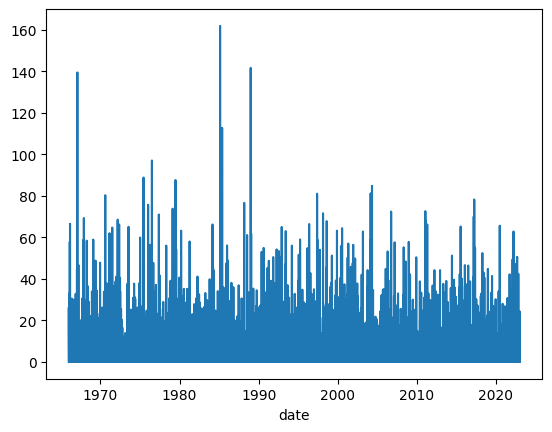

In [105]:
rain = auckland_rain['rainfall(mm)']
rain.plot()

In [106]:
# create 7 days lag

def rain_to_X_y(df, lag_size = 7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - lag_size):
        features = df_as_np[i: i + lag_size]
        label = df_as_np[i + lag_size] 
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y)

rain_to_X_y(auckland_rain)

(array([[[Timestamp('1966-01-01 00:00:00'), 0.0, 18.0, 22.2, 13.9],
         [Timestamp('1966-01-02 00:00:00'), 26.2, 20.5, 23.9, 17.1],
         [Timestamp('1966-01-03 00:00:00'), 0.0, 20.3, 23.5, 17.1],
         ...,
         [Timestamp('1966-01-05 00:00:00'), 1.3, 20.6, 23.4, 17.8],
         [Timestamp('1966-01-06 00:00:00'), 8.9, 21.0, 23.4, 18.6],
         [Timestamp('1966-01-07 00:00:00'), 5.1, 20.0, 23.7, 16.3]],
 
        [[Timestamp('1966-01-02 00:00:00'), 26.2, 20.5, 23.9, 17.1],
         [Timestamp('1966-01-03 00:00:00'), 0.0, 20.3, 23.5, 17.1],
         [Timestamp('1966-01-04 00:00:00'), 0.0, 20.3, 24.4, 16.2],
         ...,
         [Timestamp('1966-01-06 00:00:00'), 8.9, 21.0, 23.4, 18.6],
         [Timestamp('1966-01-07 00:00:00'), 5.1, 20.0, 23.7, 16.3],
         [Timestamp('1966-01-08 00:00:00'), 1.3, 19.7, 22.1, 17.3]],
 
        [[Timestamp('1966-01-03 00:00:00'), 0.0, 20.3, 23.5, 17.1],
         [Timestamp('1966-01-04 00:00:00'), 0.0, 20.3, 24.4, 16.2],
         [Ti

In [107]:
X, y = rain_to_X_y(auckland_rain)

X_train, y_train = X[:18000], y[:18000]
X_val, y_val = X[18000:20000], y[18000:20000]
X_test, y_test = X[:20000], y[:20000]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((18000, 7, 5), (18000, 5), (2000, 7, 5), (2000, 5), (20000, 7, 5), (20000, 5))

In [108]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.losses import MeanSquaredError
from tensorflow.python.keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

from tensorflow.python.keras.layers.recurrent import LSTM
sequence_length = 7

lstmModel = Sequential()
lstmModel.add(LSTM(64, input_shape=(sequence_length, 1)))
lstmModel.add(Dense(8, activation='relu'))
lstmModel.add(Dense(1, activation='linear'))

lstmModel.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Compile the model with the instantiated optimizer
lstmModel.compile(loss=MeanSquaredError(), optimizer="adam", metrics=[RootMeanSquaredError()])
history = lstmModel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)



AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'